<a href="https://colab.research.google.com/github/shauryajain1/MovieSentimentAnalysis/blob/main/MovieSentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import re
import time
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('/content/IMDB Dataset.csv')

In [4]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
data.shape

(50000, 2)

In [6]:
data.isnull().sum()

,0
review,0
sentiment,0


In [7]:
data.columns

Index(['review', 'sentiment'], dtype='object')

In [8]:
pd.Index(['review', 'sentiment'], dtype='object')

Index(['review', 'sentiment'], dtype='object')

In [9]:
def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return ' '.join(text.split())

data['cleaned_review'] = data['review'].apply(preprocess_text)

In [10]:
data[['review', 'cleaned_review', 'sentiment']].head()

,review,cleaned_review,sentiment
0,One of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,a wonderful little production the filming tech...,positive
2,I thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,basically theres a family where a little boy j...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love in the time of money is a ...,positive


In [11]:
label_encoder = LabelEncoder()
data['sentiment'] = label_encoder.fit_transform(data['sentiment'])

In [12]:
X = data['cleaned_review']
y = data['sentiment']

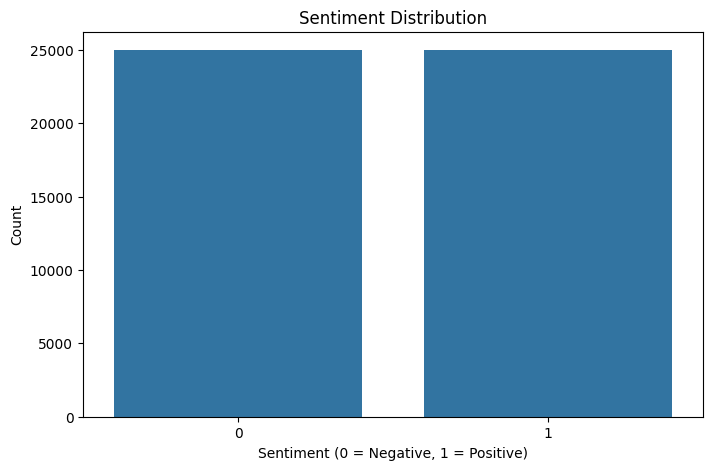

In [13]:
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=data)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment (0 = Negative, 1 = Positive)')
plt.ylabel('Count')
plt.show()

In [14]:
data_sample = data.sample(frac=0.1, random_state=42)
X = data_sample['cleaned_review']
y = data_sample['sentiment']


In [15]:
vectorizer = TfidfVectorizer(max_features=1800, min_df=5, max_df=0.9)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)


In [16]:
classifiers = {
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=20, max_samples=0.8, n_jobs=-1, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1)
}

In [17]:
results={}
training_times = {}
for name, clf in classifiers.items():
    start_time = time.time()

    clf.fit(X_train_vectorized, y_train)

    training_time = time.time() - start_time
    training_times[name] = training_time
    print(f"{name} training took: {training_time:.2f} seconds")

    y_pred = clf.predict(X_test_vectorized)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

    results[name] = {
        'accuracy': accuracy,
        'y_pred': y_pred,
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

classifier_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in classifier_names]

Naive Bayes training took: 0.01 seconds
Naive Bayes Accuracy: 0.8300
Random Forest training took: 1.21 seconds
Random Forest Accuracy: 0.8060
KNN training took: 0.00 seconds
KNN Accuracy: 0.6930
Logistic Regression training took: 1.12 seconds
Logistic Regression Accuracy: 0.8480
Decision Tree training took: 1.84 seconds
Decision Tree Accuracy: 0.6710
XGBoost training took: 11.55 seconds
XGBoost Accuracy: 0.8160


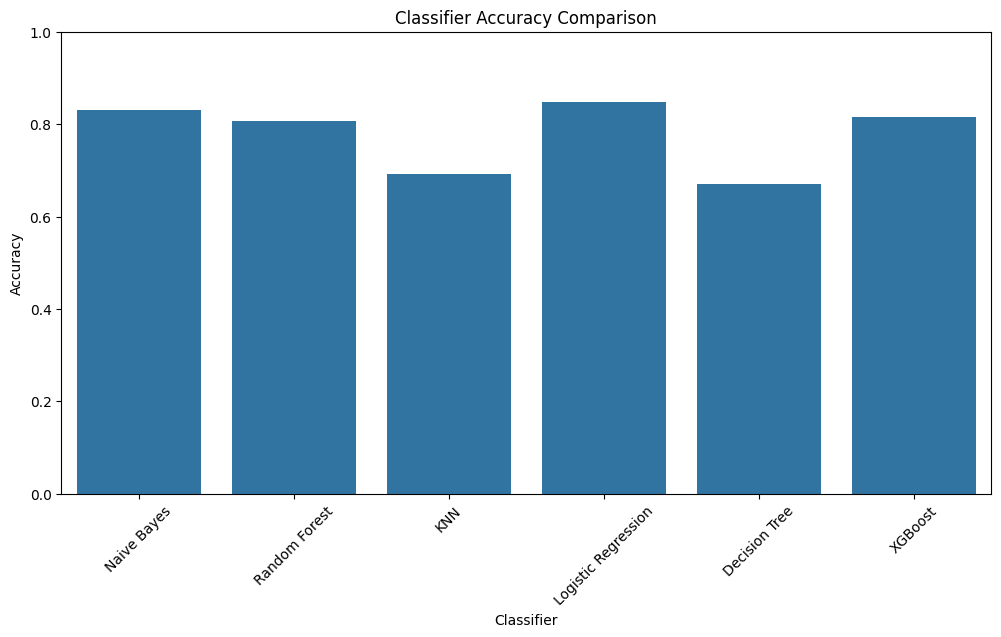

In [18]:
plt.figure(figsize=(12, 6))
sns.barplot(x=classifier_names, y=accuracies)
plt.title('Classifier Accuracy Comparison')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

In [19]:
y_true = y_test
y_pred_rf = results['Random Forest']['y_pred']
correct_predictions = sum(y_true == y_pred_rf)
incorrect_predictions = sum(y_true != y_pred_rf)

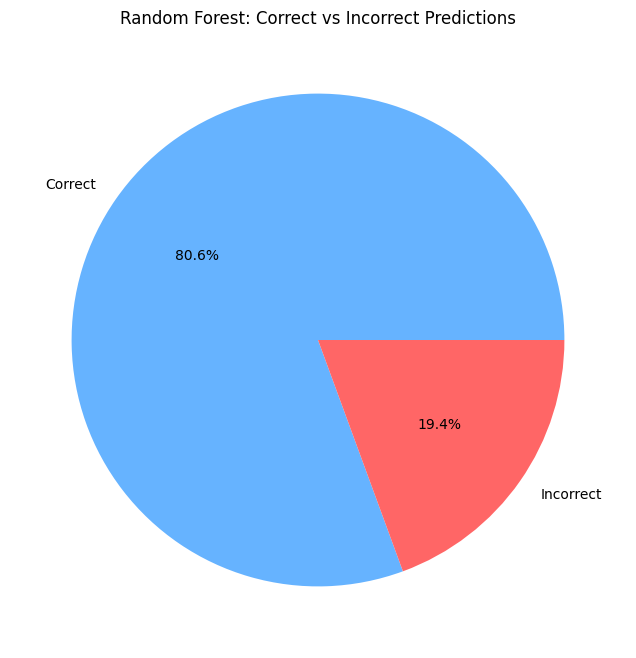

In [20]:
plt.figure(figsize=(8, 8))
plt.pie([correct_predictions, incorrect_predictions], labels=['Correct', 'Incorrect'], autopct='%1.1f%%', colors=['#66b3ff','#ff6666'])
plt.title('Random Forest: Correct vs Incorrect Predictions')
plt.show()

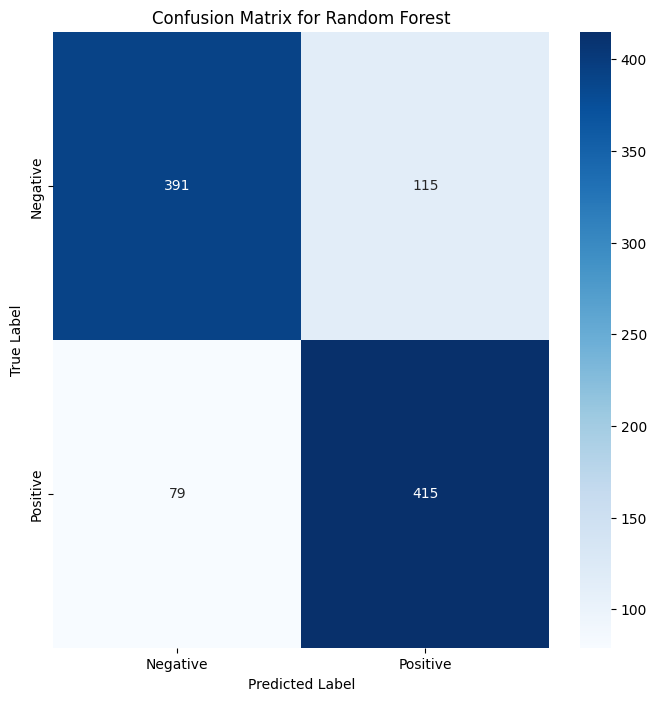

In [21]:
conf_matrix_rf = results['Random Forest']['confusion_matrix']
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

<Figure size 1200x600 with 0 Axes>

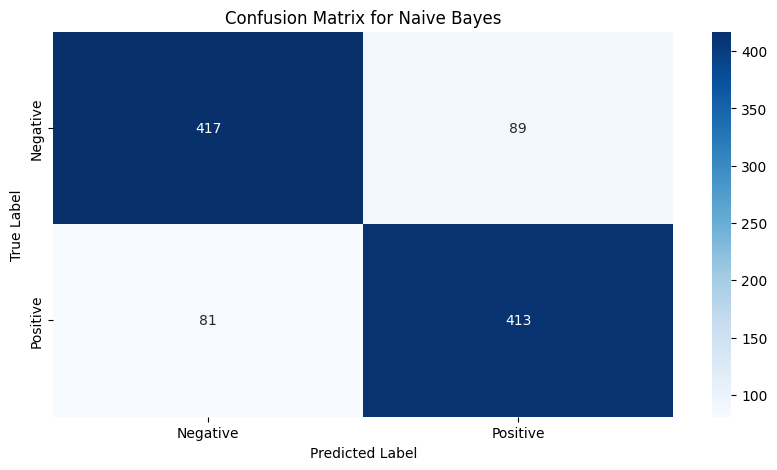

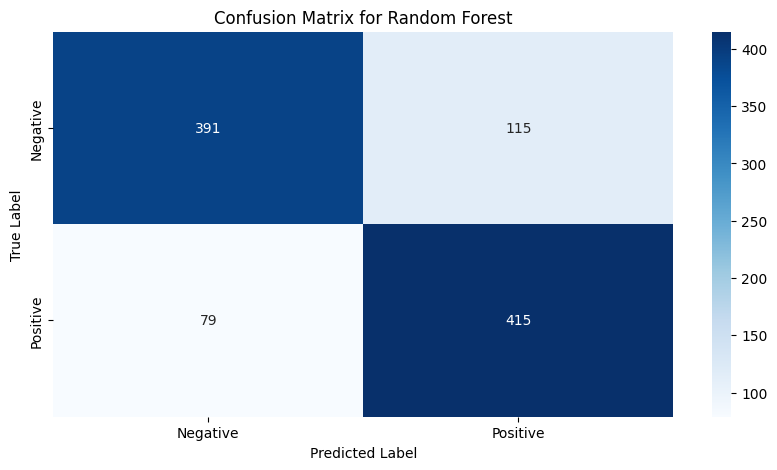

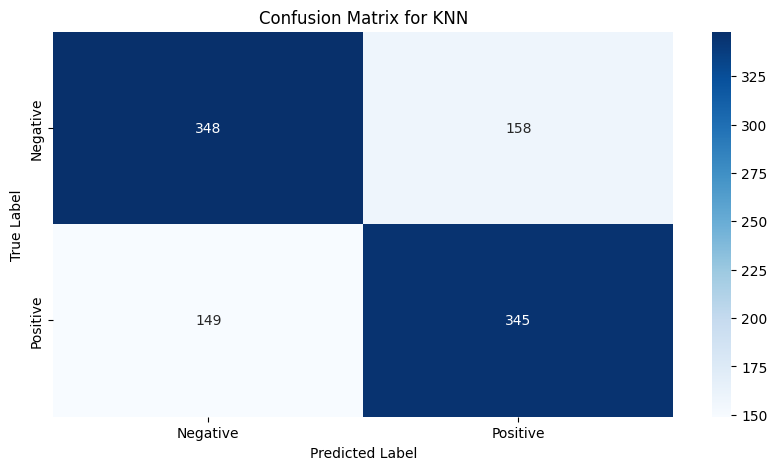

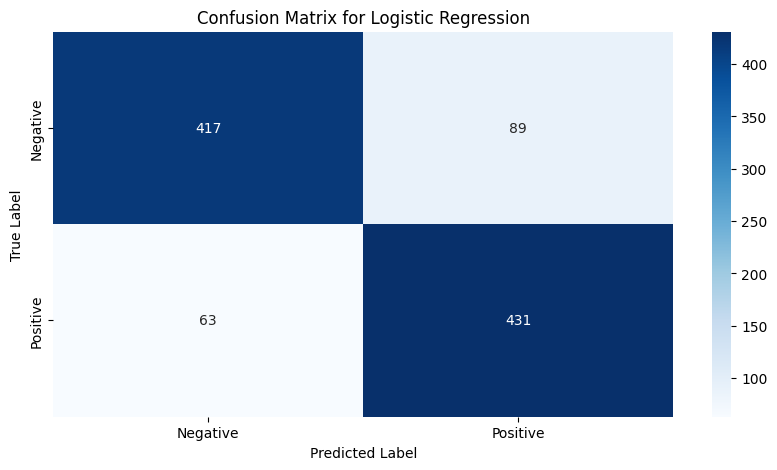

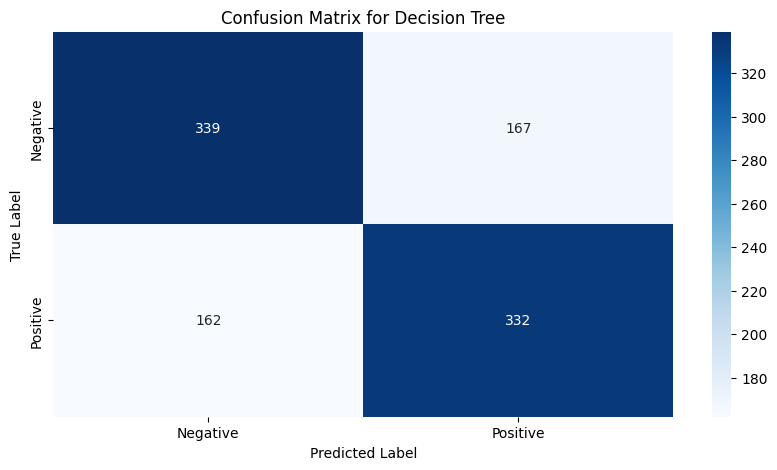

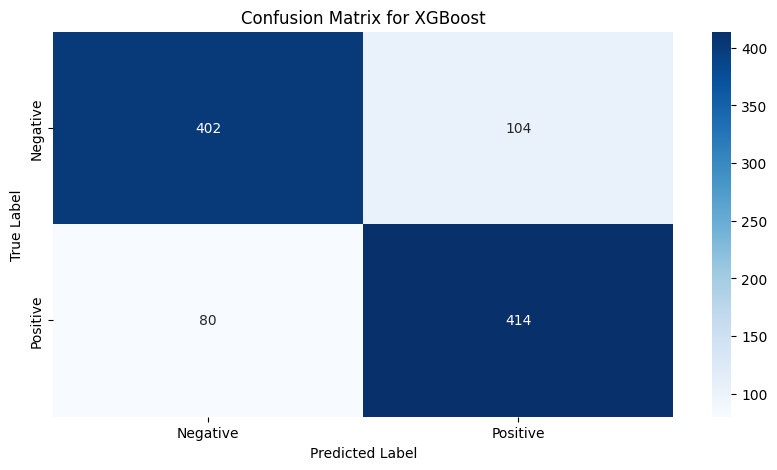

In [22]:
plt.figure(figsize=(12, 6))
for name in results:
    conf_matrix = results[name]['confusion_matrix']
    plt.figure(figsize=(10, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [24]:
def predict_sentiment(review):
    review_vectorized = vectorizer.transform([preprocess_text(review)])
    predictions = {name: clf.predict(review_vectorized)[0] for name, clf in classifiers.items()}
    predictions = {name: label_encoder.inverse_transform([pred])[0] for name, pred in predictions.items()}
    return predictions

while True:
    user_review = input("Enter a movie review (or type 'exit' to quit): ")
    if user_review.lower() == 'exit':
        break
    predictions = predict_sentiment(user_review)
    for classifier, sentiment in predictions.items():
        print(f"{classifier} Prediction: {sentiment}")

Enter a movie review (or type 'exit' to quit): the movie was fantastic
Naive Bayes Prediction: positive
Random Forest Prediction: positive
KNN Prediction: positive
Logistic Regression Prediction: positive
Decision Tree Prediction: positive
XGBoost Prediction: positive
Enter a movie review (or type 'exit' to quit): exit
